# Jupyter Pipeline for Mouse Simulation

### Outputs Time Series Matrix, Parameters, FCM and SCM vs FCM Spearson Correlation

In [2]:
# First Import the packages.
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
from scipy import stats
#matplotlib.style.use('ggplot')
import inspect
import os
import csv 
import time

## Main adjustments below, can hopefully get away with only changing cell below!

In [52]:
# Set up input Parameters for entire pipeline as dictionary elements here:

# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "3regions"

# Monitors or not?  (Aka BOLD or not?)
ParamsDict["BOLD"] = False

# Change to Binary Connectome? (If True, will change the connectome into binary)
ParamsDict["BINARY"] = True

# Snip is the the number of elements you wish to snip at the start to remove the initial condition effects.
ParamsDict["Snip"] = 10
# Note, if BOLD = False, Snip gets multiplied by 1000. 
if ParamsDict["BOLD"] == False:
    ParamsDict["Snip"] = 100 * ParamsDict["Snip"]

# Set the Random State/Seed for the Stochastic Integrator:
ParamsDict["RandState"] = 118

# Set Simulation Length:
ParamsDict["Simul_length"] = 1.2e3

# Set Linear Coupling Constant:
ParamsDict["G"] = np.array([0.47])

# Set integrator time step dt.
ParamsDict["dt"] = 0.1

# Set Additive Noise strength
ParamsDict["noise"] = np.array([0.000013])  

# Params Dict tag (extra note tags for the name - Example to denote what's being changed/looped.)
ParamsDict["tag"] = "Single"

# Set Wilson Cowan Model Parameters
ParamsDict["MODEL_c_ee"] = np.array([11.0])
ParamsDict["MODEL_c_ei"] = np.array([10.0])
ParamsDict["MODEL_c_ie"] = np.array([10.0])
ParamsDict["MODEL_c_ii"] = np.array([1.0])

# Define the model. 
ParamsDict["MODEL"] = models.WilsonCowan(c_ee=ParamsDict["MODEL_c_ee"],c_ei=ParamsDict["MODEL_c_ei"],c_ie=ParamsDict["MODEL_c_ie"] ,c_ii=ParamsDict["MODEL_c_ii"],
                                        a_e=numpy.array([1.0]),a_i=numpy.array([1.0]),b_e=numpy.array([1.3]),b_i=numpy.array([2.8]),tau_e=numpy.array([10.0]),
                                        tau_i=numpy.array([65.0])) 


# models.WilsonCowan(c_ee=np.array([0,11,0,0,0]),c_ei=np.array([0,10,0,0,0]),c_ie=np.array([0,10,0,0,0]),c_ii=np.array([0,11,0,0,0]),b_e=2.5,b_i=3) 
# models.WilsonCowan(c_ee=np.arange(11,19,2),c_ei=10,c_ie=10,c_ii=1,b_e=2.5,b_i=3) 
# models.WilsonCowan(c_ee=np.arange(11,16,1)) 
# models.WilsonCowan()

# models.ReducedWongWang(w=1.0, I_o=0.3)
# models.ReducedWongWang(w=1.0, I_o=0.3)

#models.WilsonCowan(r_e=1.0,r_i=1.0,b_e=4.0,b_i=4.0,alpha_e=1.0,alpha_i=2.0,P=0)

In [63]:
# Load the connectivity data from a zip file. 
con = connectivity.Connectivity.from_file("C:\\Users\\Pok Him\\Desktop\\MouseBrainModelling\\Connectomes\\" + ParamsDict["name"] + ".zip")

# Mouse Allen Connectivity (from within TVB)
# con = connectivity.Connectivity.from_file("../mouse/allen_2mm/Connectivity.h5")

# Change to Connectome to Binary if desired:
if ParamsDict["BINARY"]==True:
    con.weights = con.weights!=0

WARNING  File 'hemispheres' not found in ZIP.
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Pok Him\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\Users\Pok Him\Anaconda3\lib\logging\handlers.py", line 394, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\Pok Him\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Pok Him\\.tvb-temp\\logs\\library.log' -> 'C:\\Users\\Pok Him\\.tvb-temp\\logs\\library.log.2020-07-28'
Call stack:
  File "C:\Users\Pok Him\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Pok Him\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\Users\Pok Him\TVB\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_inst

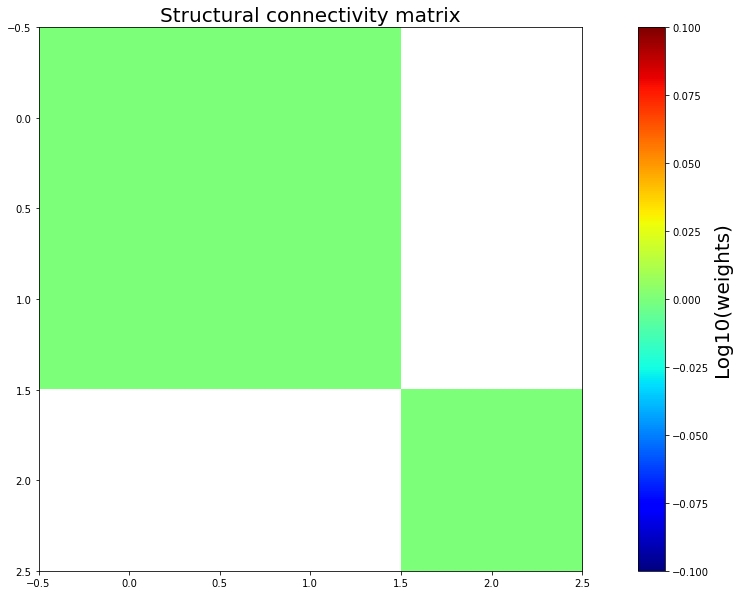

In [64]:
# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(con.weights), cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)
#plt.yticks([0,1,2,3])

In [80]:
# Set the parameter of the resting state simulation

if ParamsDict["BOLD"] == True:
    sim = simulator.Simulator(model=ParamsDict["MODEL"],
                            connectivity=con,
                            coupling=coupling.Linear(a=ParamsDict["G"]),
                            integrator=integrators.HeunStochastic(dt=ParamsDict["dt"],noise=noise.Additive(nsig=ParamsDict["noise"],
                                        random_stream=np.random.RandomState(ParamsDict["RandState"]))),
                            monitors=(monitors.Bold(period=2e3),
                                      monitors.TemporalAverage(period=1e3)),
                            simulation_length=ParamsDict["Simul_length"],
                            #initial_conditions=[1.8,1.8,1.8,1.8,1.8]
                            ).configure()
    # Run the resting state simulation
    (bold_time, bold_data), _ = sim.run()

    # Display the simulated bold timeseries
    plt.subplots()
    plt.plot(bold_time,bold_data[:,0,:,0])
    plt.xlabel('Time (ms)', fontsize=20)
    plt.ylabel('Amplitude (au)', fontsize=20)
    plt.title('Simulated BOLD timeseries', fontsize=20)
    plt.legend(('0','1','2','3','4'))

# No Monitors 
else:

  sim = simulator.Simulator(model=ParamsDict["MODEL"],
                          connectivity=con,
                          coupling=coupling.Linear(a=ParamsDict["G"]),
                          integrator=integrators.EulerStochastic(dt=ParamsDict["dt"],noise=noise.Additive(nsig=ParamsDict["noise"],
                                        random_stream=np.random.RandomState(ParamsDict["RandState"]))),
                          simulation_length=ParamsDict["Simul_length"],
                          initial_conditions=( np.array([0,0]),np.array([0,0]),np.array([0,0]),np.array([0,0]))
                          ).configure()
  # Run the resting state simulation
  awer = sim.run()
  bold_time = awer[0][0]
  bold_data = awer[0][1]

  # Display the simulated non-bold timeseries
# Display the simulated non-bold timeseries
  plt.subplots()
  plt.plot(bold_time,bold_data[:,0,:,0])
  plt.xlabel('Time (ms)', fontsize=20)
  plt.ylabel('Amplitude (au)', fontsize=20)
  plt.title('Simulated non-BOLD timeseries', fontsize=20)
  plt.legend(('0','1','2','3','4'))
  plt.grid()

TraitTypeError: Attribute can't be set to an instance of <class 'tuple'>
  attribute tvb.simulator.simulator.Simulator.initial_conditions = NArray(label='Initial Conditions', dtype=float64, default=None, dim_names=(), ndim=None, required=False)

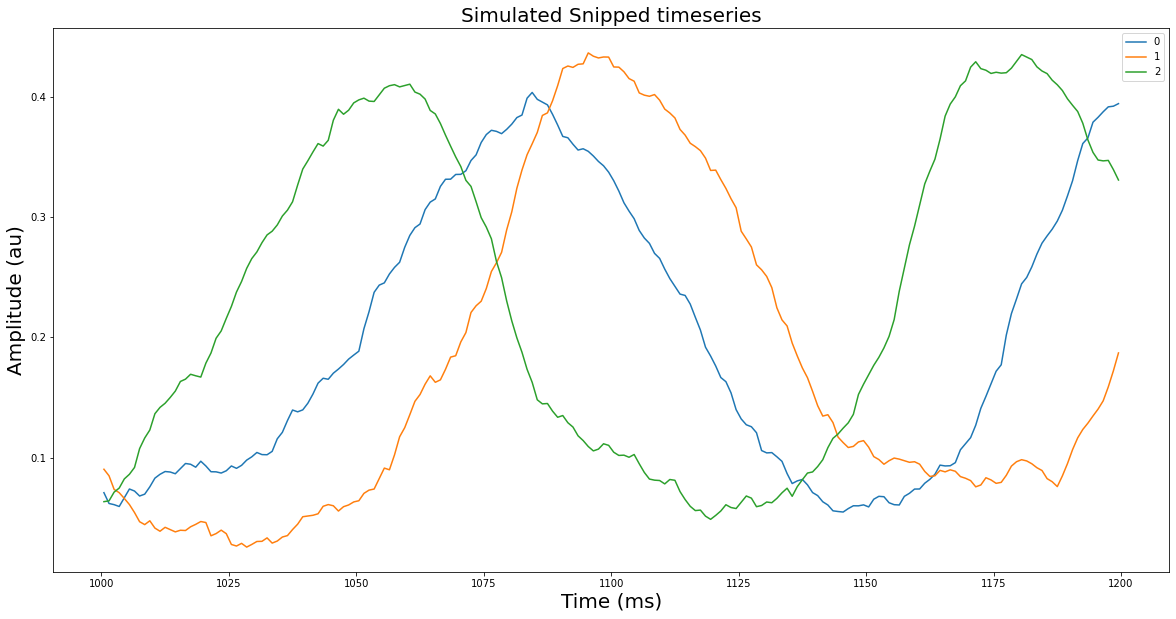

In [70]:
# Display the simulated snipped timeseries

# Got lazy
Snip = ParamsDict["Snip"]
plt.subplots()
plt.plot(bold_time[Snip:],bold_data[Snip:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated Snipped timeseries', fontsize=20)
plt.legend(('0','1','2','3','4'))

In [67]:
# Functional Connectivity Matrix. 

# We note that this is a static analysis.  More advanced version would be a DYnamic version with windowing.

# Convert Simulation output into a form usable by Numpy.
TSeriesMatrix = np.empty((bold_data.shape[2], bold_data.shape[0]-Snip))
#Matrix = []

for i in range(bold_data.shape[2]):
    TSeriesMatrix[i] = bold_data[Snip:,0,i].flatten()

# Functional Conenctivity MAtrix = Pearson Correlation.

FCM = np.corrcoef(TSeriesMatrix)
FCM

array([[ 1.        ,  0.58802714,  0.21283924],
       [ 0.58802714,  1.        , -0.54358359],
       [ 0.21283924, -0.54358359,  1.        ]])

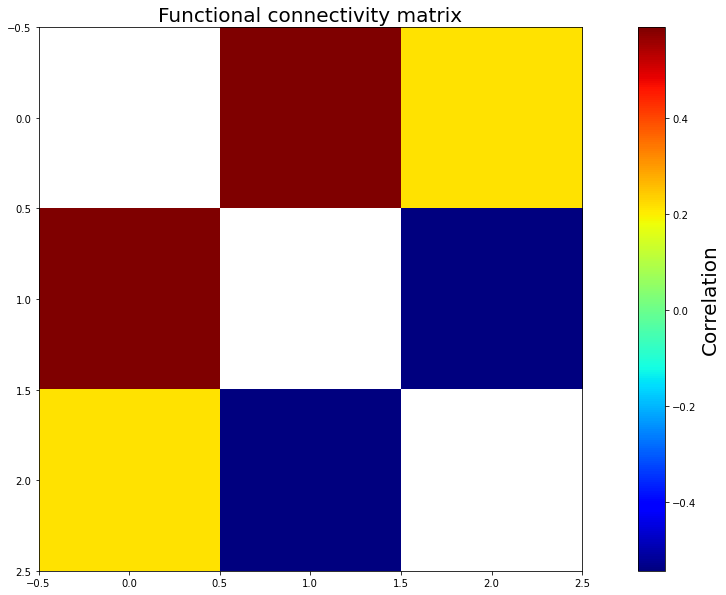

In [68]:
# Plot Matrix
# Set diagonals to NaN
FCM1 = FCM
np.fill_diagonal(FCM1,np.nan)

cs=plt.imshow(FCM1, cmap='jet', aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

In [61]:
# Comparing SC vs FC with Spearman Corr
# Check if SCM is symmetric: 
SCM = con.weights
Sym_check = numpy.allclose(SCM, SCM.T,equal_nan=True)

if Sym_check == True:
    #It is a symmetric SCM, so only use upper triangles
    # Grab Upper triangles
    FCM_Upper = FCM[np.triu_indices(FCM.shape[0], k = 1)]
    SCM_Upper = con.weights[np.triu_indices(con.weights.shape[0], k = 1)]

elif Sym_check == False:
    # If SCM is not symmetric, need to calcualte spearman corr for entire matrix.
    # Set Diagonal to Nans
    np.fill_diagonal(SCM,np.nan)
    # Remove all Nans for SCM and FCM
    SCM_Upper = SCM[~numpy.isnan(SCM)]
    FCM_Upper = FCM1[~numpy.isnan(FCM1)]

# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
print(SCorr)

SpearmanrResult(correlation=nan, pvalue=nan)


Text(0.05, 0.95, 'SpearmanrResult(correlation=nan, pvalue=nan)')

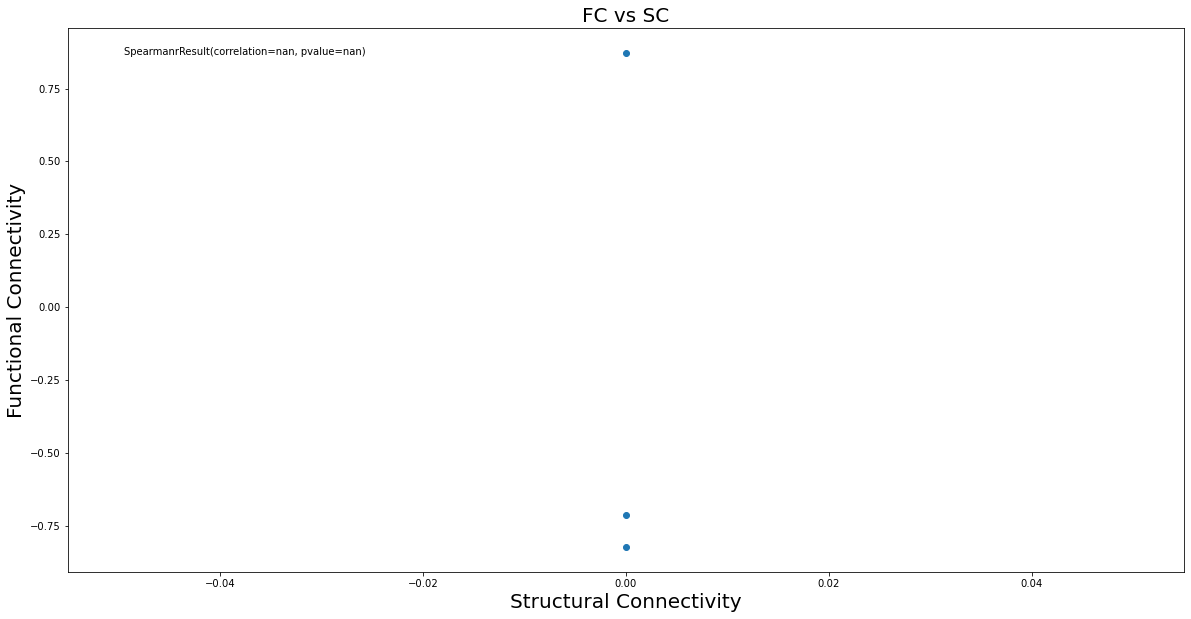

In [62]:
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('Structural Connectivity', fontsize=20)
plt.ylabel('Functional Connectivity', fontsize=20)
plt.title('FC vs SC', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')

In [11]:
# Export the simulation

time_now = time.strftime("%Y%m%d-%H%M%S")

# Params Dictionary - Note how we sort the dictionary.
with open("do-not-track/" + ParamsDict["tag"] + "_" + ParamsDict["name"] + "_Params_" + time_now + "_.csv", "w") as outfile:
    writer = csv.writer(outfile)
    for key, val in sorted(ParamsDict.items()):
        writer.writerow([key, val])
    
# Create Time Series and save. 
TSeries = np.concatenate((bold_time[Snip:].reshape(1,len(bold_time[Snip:])),TSeriesMatrix))
np.savetxt("do-not-track/" + ParamsDict["tag"] + "_" + ParamsDict["name"] + "_Tseries_" + time_now + "_.csv", TSeries, delimiter="\t")
np.savetxt("do-not-track/" + ParamsDict["tag"] + "_" + ParamsDict["name"]  + "_FCM_" + time_now + "_.csv", FCM, delimiter = "\t")
np.savetxt("do-not-track/" + ParamsDict["tag"] + "_" + ParamsDict["name"]  + "_Scorr_" +  time_now + "_.csv", SCorr, delimiter = "\t")  